In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join

import energyflow as ef
import h5py
import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf
from sklearn.neighbors import KernelDensity
import pandas as pd

2023-09-13 14:40:49.038199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 14:40:49.735083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import (
    calculate_all_wasserstein_metrics,
    inverse_normalize_tensor,
    normalize_tensor,
)
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, plot_data, prepare_data_for_plotting

apply_mpl_styles()

In [4]:
from jetnet.evaluation import w1efp, w1m, w1p
from src.utils.jet_substructure import dump_hlvs
from src.data.components.metrics import wasserstein_distance_batched
from src.utils.plotting import (
    plot_substructure,
    plot_full_substructure,
)

In [5]:
# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

In [6]:
data_folder = os.environ.get("DATA_DIR")

## load data

In [7]:
# load data 
path_true_data = "/beegfs/desy/user/ewencedr/data/lhco/generated/idealized_LHCO.h5"
with h5py.File(path_true_data, "r") as f:
    jet_features_id = f["jet_features"][:]
    particle_data_id = f["particle_features"][:]
    mjj_id = f["mjj"][:]

In [8]:
# load data 
path_true_datav = "/beegfs/desy/user/ewencedr/data/lhco/generated/FPCD_LHCO_SR.h5"
with h5py.File(path_true_datav, "r") as f:
    jet_features_v = f["jet_features"][:]
    particle_data_v = f["particle_features"][:]
    mjj_v = f["mjj"][:]

In [9]:
# load data 
path_true_datac = "/beegfs/desy/user/ewencedr/data/lhco/generated/lhco-xy-10layer-256latent-logpt-new2m_sr-midpoint-300.h5"
with h5py.File(path_true_datac, "r") as f:
    jet_features_c = f["jet_features"][:]
    particle_data_c = f["particle_features"][:]
    mjj_c = f["mjj"][:]

In [10]:
print(jet_features_id.shape)
print(jet_features_v.shape)
print(jet_features_c.shape)

(121351, 2, 5)
(200000, 2, 5)
(121351, 2, 5)


In [11]:
jet_features_v = jet_features_v[:len(jet_features_id)]
particle_data_v = particle_data_v[:len(jet_features_id)]
mjj_v = mjj_v[:len(jet_features_id)]
print(jet_features_id.shape)
print(jet_features_v.shape)
print(jet_features_c.shape)

(121351, 2, 5)
(121351, 2, 5)
(121351, 2, 5)


both jets

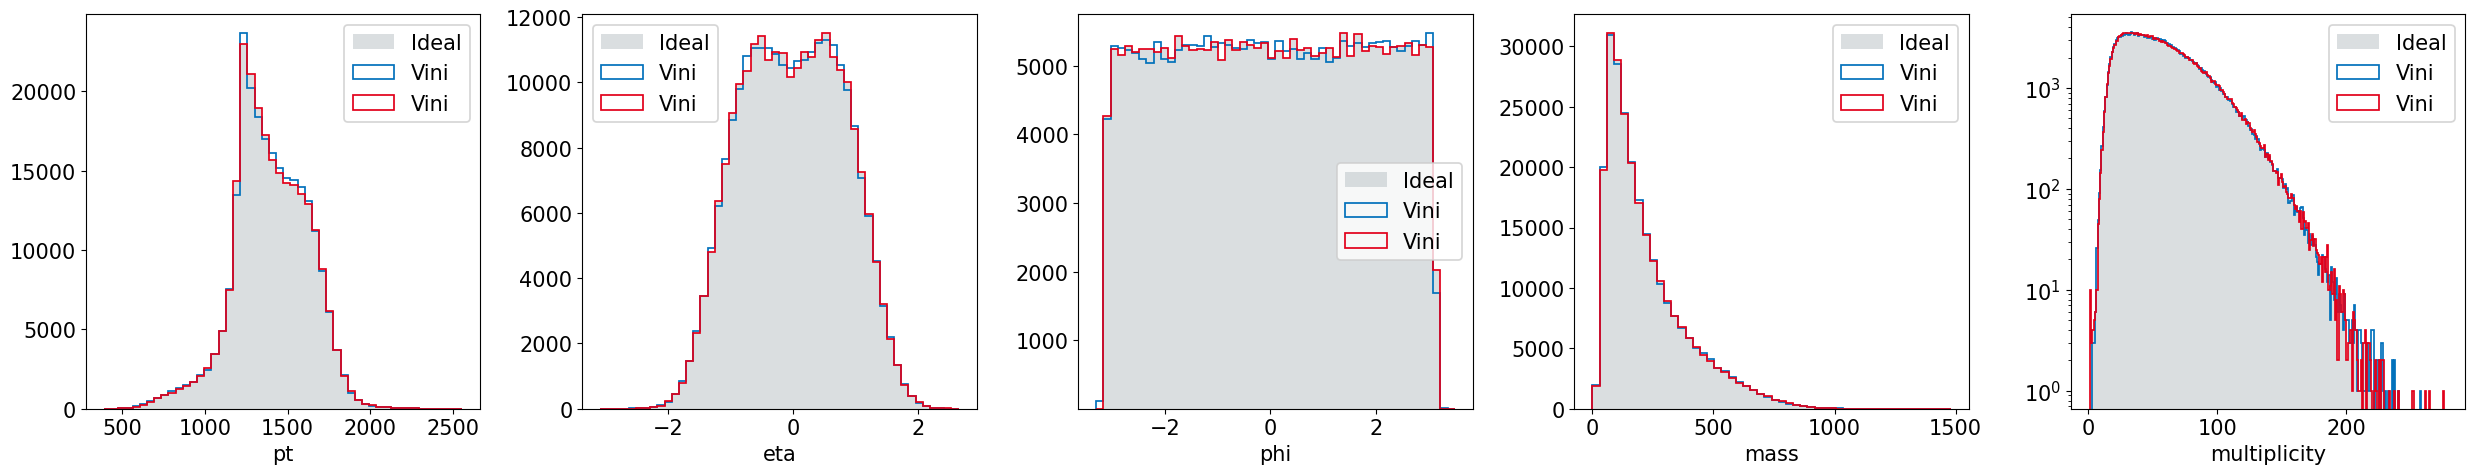

In [12]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(jet_features_id[..., i]), np.min(jet_features_v[...,i]), np.min(jet_features_c[...,i])), max(np.max(jet_features_id[..., i]), np.max(jet_features_v[...,i]), np.max(jet_features_c[...,i]))
    
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 50
    hist = ax.hist(jet_features_id[..., i].flatten()[jet_features_id[..., i].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    ax.hist(jet_features_v[..., i].flatten()[jet_features_v[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    ax.hist(jet_features_c[..., i].flatten()[jet_features_c[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    ax.set_xlabel(labels[i])
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

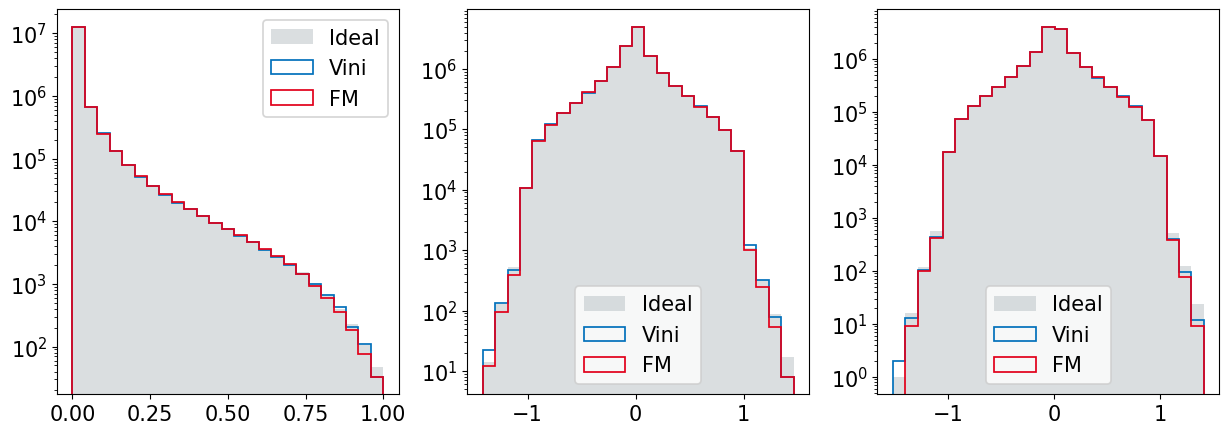

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(particle_data_id[..., i]), np.min(particle_data_v[...,i]), np.min(particle_data_c[...,i])), max(np.max(particle_data_id[..., i]), np.max(particle_data_v[...,i]), np.max(particle_data_c[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(particle_data_id[..., i].flatten()[particle_data_id[..., i].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    hist2 = ax.hist(particle_data_v[..., i].flatten()[particle_data_v[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    ax.hist(particle_data_c[..., i].flatten()[particle_data_c[..., i].flatten() != 0], bins=hist[1], label="FM", histtype="step")
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

first jet

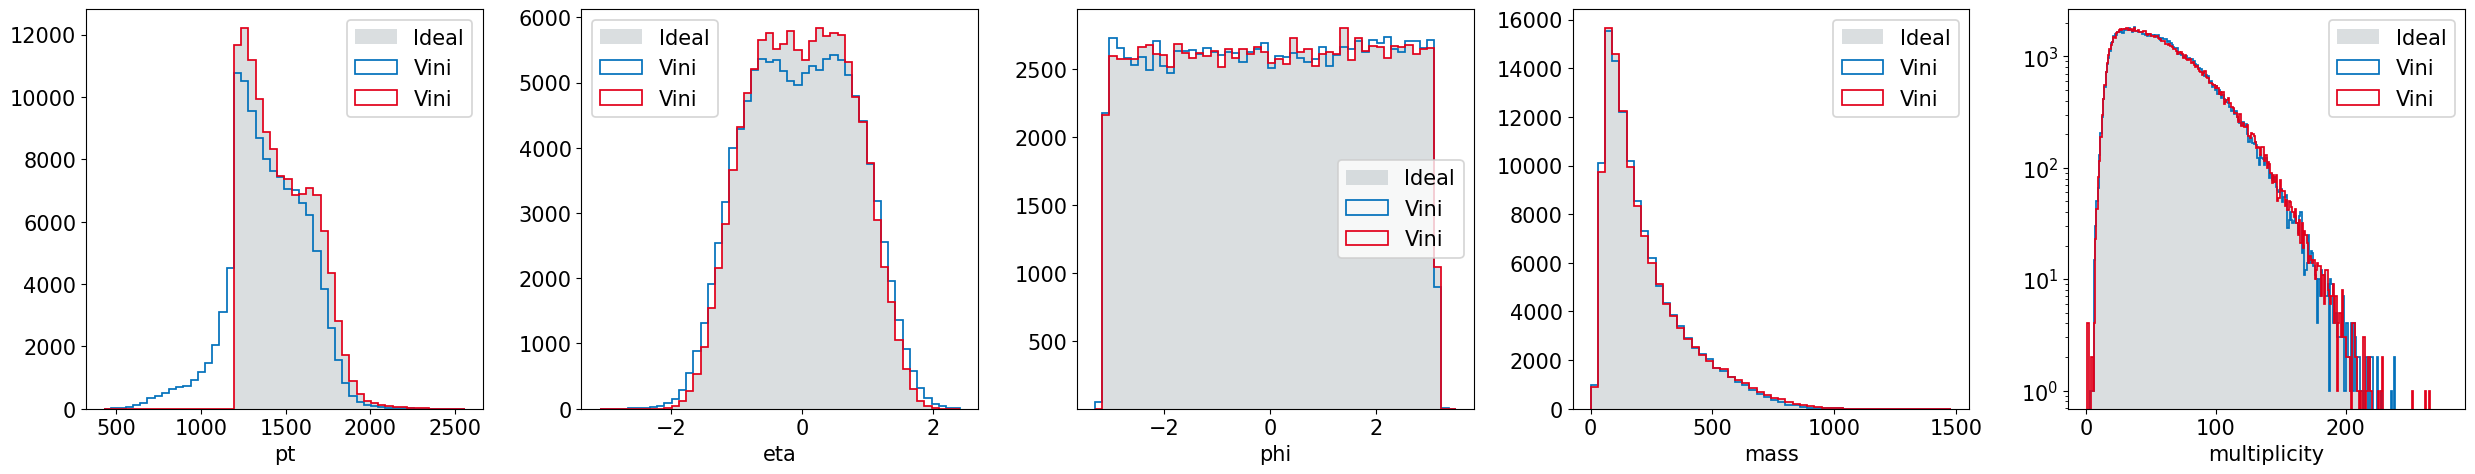

In [14]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(jet_features_id[..., i][:,0]), np.min(jet_features_v[...,i][:,0]), np.min(jet_features_c[...,i][:,0])), max(np.max(jet_features_id[..., i][:,0]), np.max(jet_features_v[...,i][:,0]), np.max(jet_features_c[...,i][:,0]))
    
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 50
    hist = ax.hist(jet_features_id[..., i][:,0].flatten()[jet_features_id[..., i][:,0].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    ax.hist(jet_features_v[..., i][:,0].flatten()[jet_features_v[..., i][:,0].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    ax.hist(jet_features_c[..., i][:,0].flatten()[jet_features_c[..., i][:,0].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    ax.set_xlabel(labels[i])
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

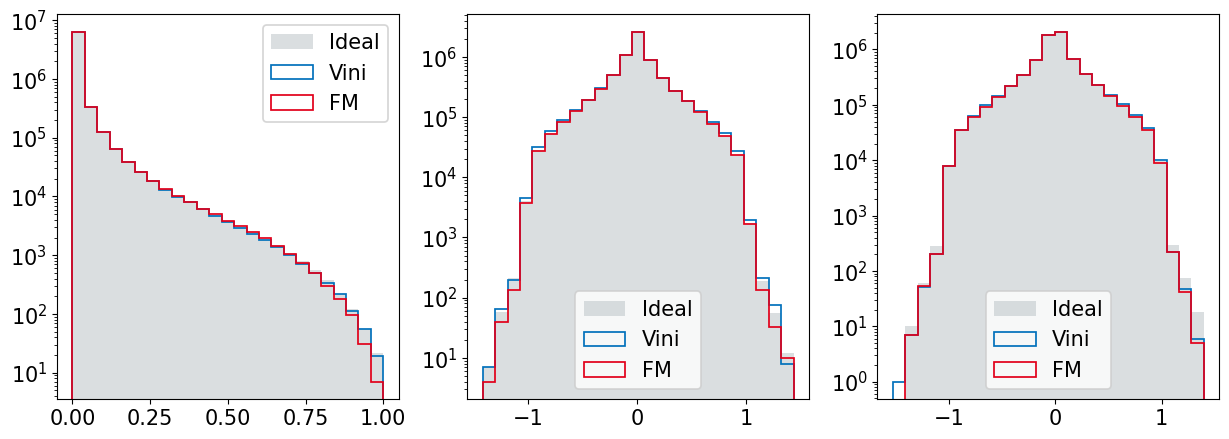

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(particle_data_id[..., i][:,0]), np.min(particle_data_v[...,i][:,0]), np.min(particle_data_c[...,i][:,0])), max(np.max(particle_data_id[..., i][:,0]), np.max(particle_data_v[...,i][:,0]), np.max(particle_data_c[...,i][:,0]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(particle_data_id[..., i][:,0].flatten()[particle_data_id[..., i][:,0].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    hist2 = ax.hist(particle_data_v[..., i][:,0].flatten()[particle_data_v[..., i][:,0].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    ax.hist(particle_data_c[..., i][:,0].flatten()[particle_data_c[..., i][:,0].flatten() != 0], bins=hist[1], label="FM", histtype="step")
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

second jet

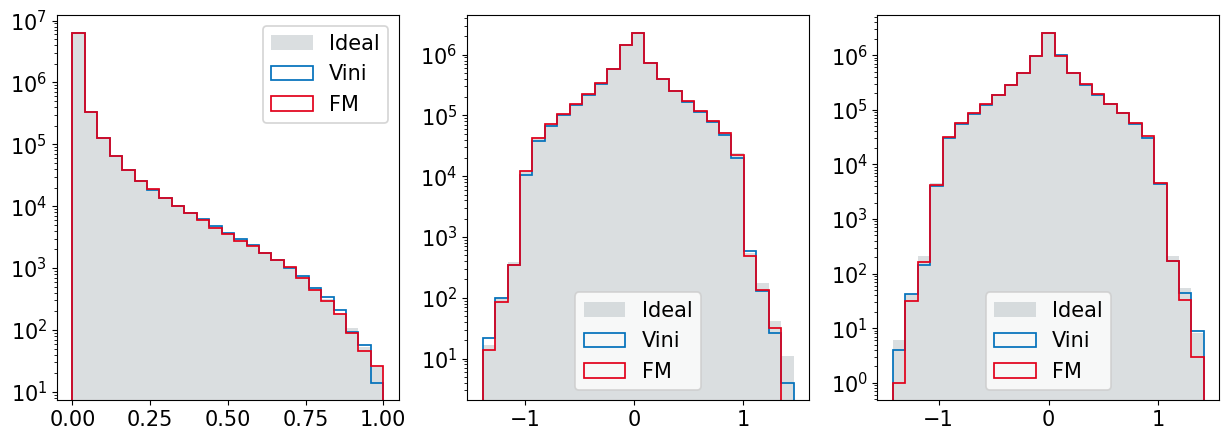

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(particle_data_id[..., i][:,1]), np.min(particle_data_v[...,i][:,1]), np.min(particle_data_c[...,i][:,1])), max(np.max(particle_data_id[..., i][:,1]), np.max(particle_data_v[...,i][:,1]), np.max(particle_data_c[...,i][:,1]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(particle_data_id[..., i][:,1].flatten()[particle_data_id[..., i][:,1].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    hist2 = ax.hist(particle_data_v[..., i][:,1].flatten()[particle_data_v[..., i][:,1].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    ax.hist(particle_data_c[..., i][:,1].flatten()[particle_data_c[..., i][:,1].flatten() != 0], bins=hist[1], label="FM", histtype="step")
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

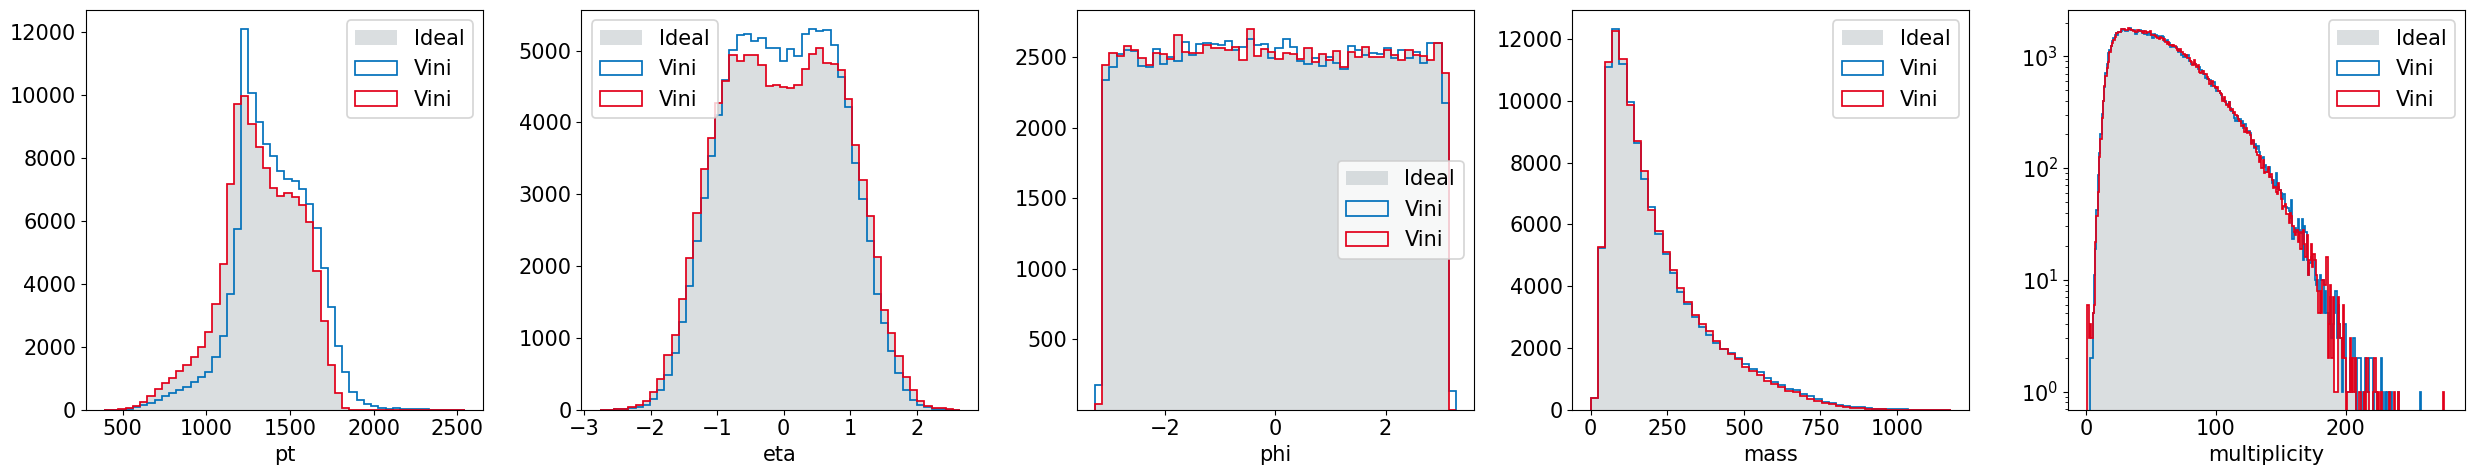

In [17]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(jet_features_id[..., i][:,1]), np.min(jet_features_v[...,i][:,1]), np.min(jet_features_c[...,i][:,1])), max(np.max(jet_features_id[..., i][:,1]), np.max(jet_features_v[...,i][:,1]), np.max(jet_features_c[...,i][:,1]))
    
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 50
    hist = ax.hist(jet_features_id[..., i][:,1].flatten()[jet_features_id[..., i][:,1].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    ax.hist(jet_features_v[..., i][:,1].flatten()[jet_features_v[..., i][:,0].flatten() != 1], bins=hist[1], label="Vini", histtype="step")
    ax.hist(jet_features_c[..., i][:,1].flatten()[jet_features_c[..., i][:,0].flatten() != 1], bins=hist[1], label="Vini", histtype="step")
    
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    ax.set_xlabel(labels[i])
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

## shuffle the jets

first sort the constituents all by pt

In [18]:
def sort_pt(array):
    
    pt = array[...,0]
    #print(pt[0,0,:10])
    eta = array[...,1]
    phi = array[...,2]
    args = np.argsort(pt, axis=-1)[...,::-1]
    #print(pt.shape)
    #print(args.shape)
    
    pt2 = np.take_along_axis(pt, args, axis=-1)
    #print(pt2[0,0,:10])
    eta2 = np.take_along_axis(eta, args, axis=-1)
    phi2 = np.take_along_axis(phi, args, axis=-1)
    return np.stack([pt2, eta2, phi2], axis=-1)

In [19]:
particle_data_id = sort_pt(particle_data_id)
particle_data_v = sort_pt(particle_data_v)
particle_data_c = sort_pt(particle_data_c)

now shuffle the data along the jet axis

In [20]:
def shuffle_jets(jets, constiuents):
    pt = jets[:,:,0]
    args = np.argsort(pt, axis=1)[:,::-1]
    #idx = np.random.rand(*jets.shape).argsort(axis=1)
    #print(idx)
    print(args.shape)
    #print(args)
    idx = np.random.rand(*args.shape).argsort(axis=1)
    args = np.take_along_axis(args, idx, axis=1)
    #perm = np.random.permutation(args.shape[])
    #print(perm)
    #args = args[perm]
    print(args)
    shuffled_jets = np.take_along_axis(jets, args[..., None], axis=1)
    shuffled_consts = np.take_along_axis(constiuents, args[..., None, None], axis=1)
    #shuffled_jets = np.take_along_axis(jets, idx, axis=1)
    #shuffled_consts = np.take_along_axis(constiuents, idx[..., None], axis=1)
    return shuffled_jets, shuffled_consts

In [21]:
print(particle_data_id.shape)
print(jet_features_id[:3,:,0])

(121351, 2, 279, 3)
[[1589.57247736 1557.25584406]
 [1520.82300974 1291.51560603]
 [1321.37013644 1249.37682974]]


In [22]:
jet_features_id_shuffled, particle_data_id_shuffled = shuffle_jets(jet_features_id, particle_data_id)
jet_features_v_shuffled, particle_data_v_shuffled = shuffle_jets(jet_features_v, particle_data_v)
jet_features_c_shuffled, particle_data_c_shuffled = shuffle_jets(jet_features_c, particle_data_c)

(121351, 2)
[[1 0]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [1 0]]
(121351, 2)
[[0 1]
 [1 0]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
(121351, 2)
[[1 0]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [23]:
print(particle_data_id_shuffled.shape)
print(jet_features_id_shuffled[:3,:,0])

(121351, 2, 279, 3)
[[1557.25584406 1589.57247736]
 [1520.82300974 1291.51560603]
 [1321.37013644 1249.37682974]]


# Look at the plots again

both jets

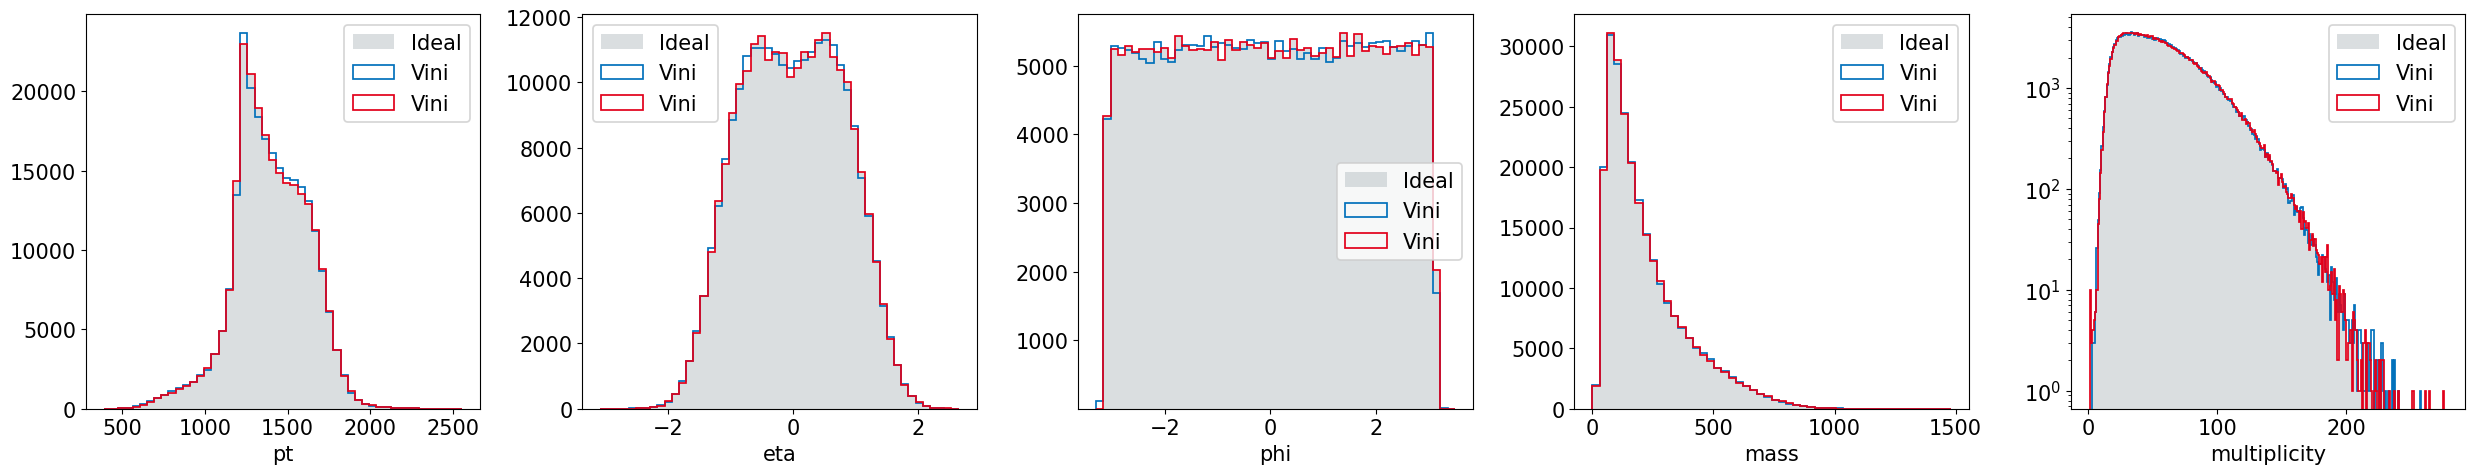

In [24]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(jet_features_id_shuffled[..., i]), np.min(jet_features_v_shuffled[...,i]), np.min(jet_features_c_shuffled[...,i])), max(np.max(jet_features_id_shuffled[..., i]), np.max(jet_features_v_shuffled[...,i]), np.max(jet_features_c_shuffled[...,i]))
    
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 50
    hist = ax.hist(jet_features_id_shuffled[..., i].flatten()[jet_features_id_shuffled[..., i].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    ax.hist(jet_features_v_shuffled[..., i].flatten()[jet_features_v_shuffled[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    ax.hist(jet_features_c_shuffled[..., i].flatten()[jet_features_c_shuffled[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    ax.set_xlabel(labels[i])
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

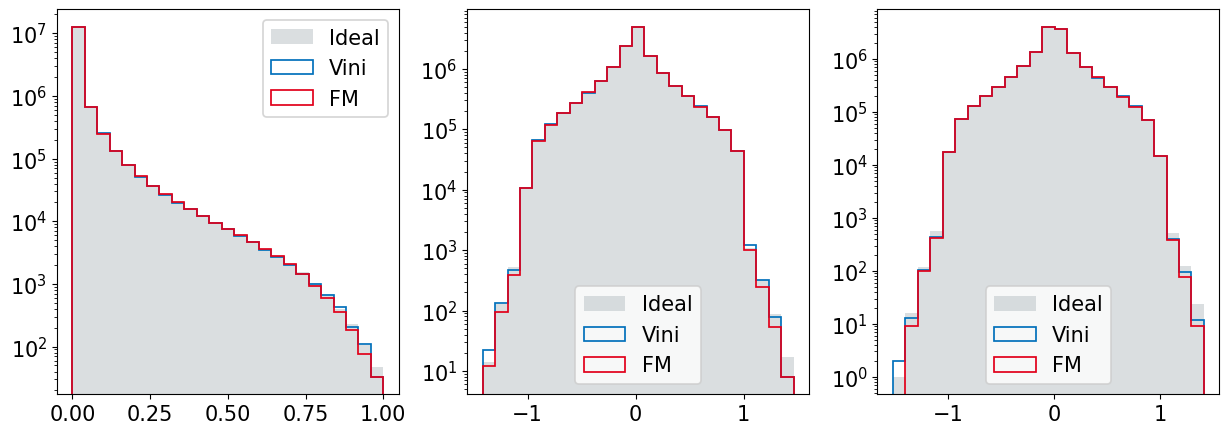

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(particle_data_id_shuffled[..., i]), np.min(particle_data_v_shuffled[...,i]), np.min(particle_data_c_shuffled[...,i])), max(np.max(particle_data_id_shuffled[..., i]), np.max(particle_data_v_shuffled[...,i]), np.max(particle_data_c_shuffled[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(particle_data_id_shuffled[..., i].flatten()[particle_data_id_shuffled[..., i].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    hist2 = ax.hist(particle_data_v_shuffled[..., i].flatten()[particle_data_v_shuffled[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    ax.hist(particle_data_c_shuffled[..., i].flatten()[particle_data_c_shuffled[..., i].flatten() != 0], bins=hist[1], label="FM", histtype="step")
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

first jet

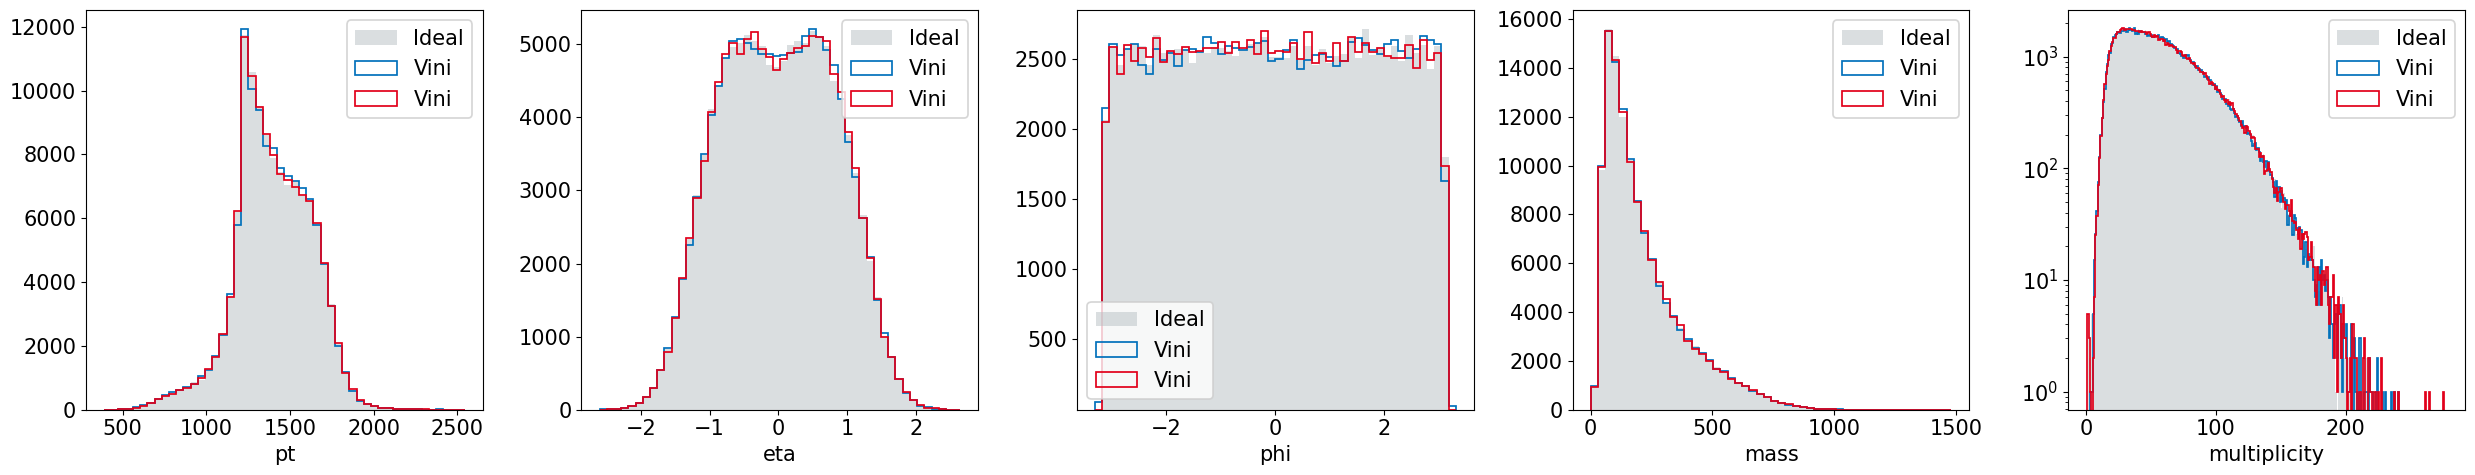

In [26]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(jet_features_id_shuffled[..., i][:,0]), np.min(jet_features_v_shuffled[...,i][:,0]), np.min(jet_features_c_shuffled[...,i][:,0])), max(np.max(jet_features_id_shuffled[..., i][:,0]), np.max(jet_features_v_shuffled[...,i][:,0]), np.max(jet_features_c_shuffled[...,i][:,0]))
    
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 50
    hist = ax.hist(jet_features_id_shuffled[..., i][:,0].flatten()[jet_features_id_shuffled[..., i][:,0].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    ax.hist(jet_features_v_shuffled[..., i][:,0].flatten()[jet_features_v_shuffled[..., i][:,0].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    ax.hist(jet_features_c_shuffled[..., i][:,0].flatten()[jet_features_c_shuffled[..., i][:,0].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    ax.set_xlabel(labels[i])
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

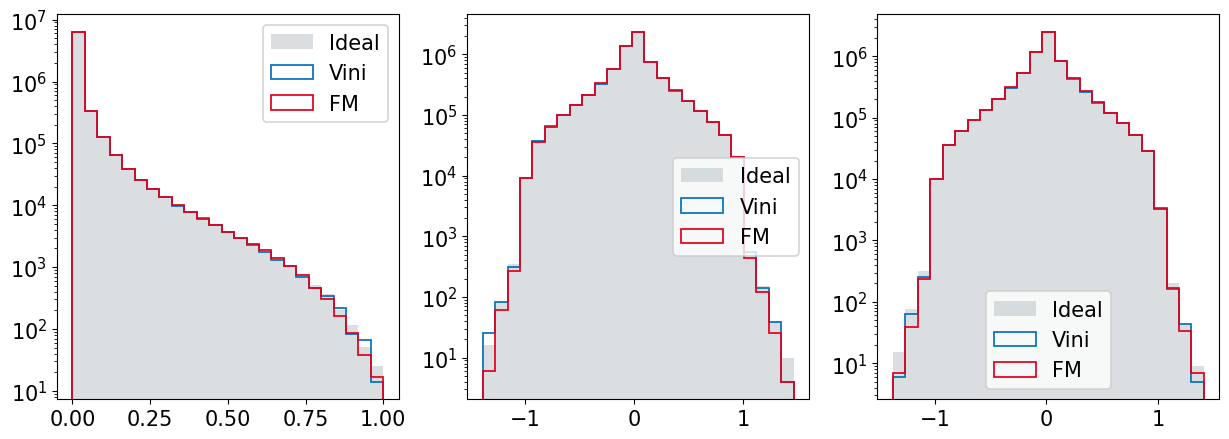

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(particle_data_id_shuffled[..., i][:,0]), np.min(particle_data_v_shuffled[...,i][:,0]), np.min(particle_data_c_shuffled[...,i][:,0])), max(np.max(particle_data_id_shuffled[..., i][:,0]), np.max(particle_data_v_shuffled[...,i][:,0]), np.max(particle_data_c_shuffled[...,i][:,0]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(particle_data_id_shuffled[..., i][:,0].flatten()[particle_data_id_shuffled[..., i][:,0].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    hist2 = ax.hist(particle_data_v_shuffled[..., i][:,0].flatten()[particle_data_v_shuffled[..., i][:,0].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    ax.hist(particle_data_c_shuffled[..., i][:,0].flatten()[particle_data_c_shuffled[..., i][:,0].flatten() != 0], bins=hist[1], label="FM", histtype="step")
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

second jet

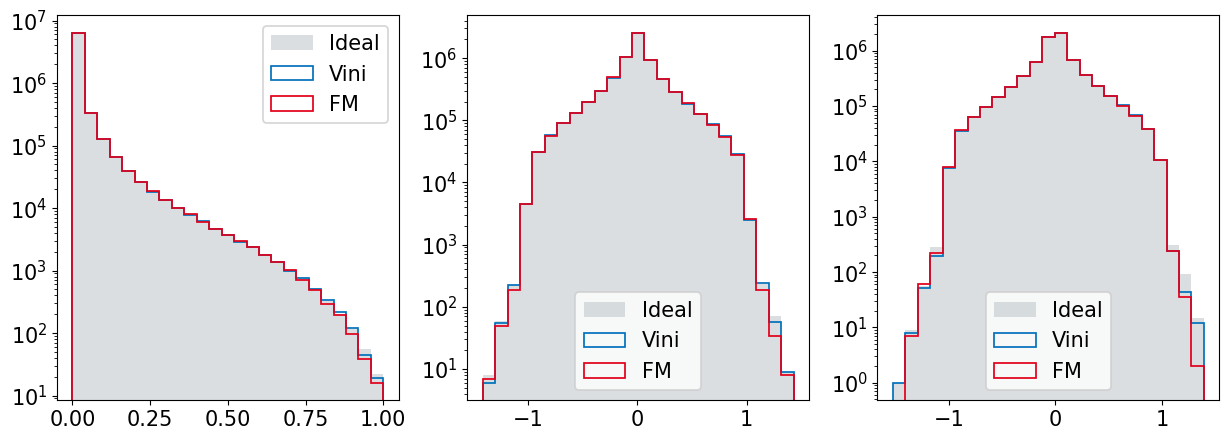

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(particle_data_id_shuffled[..., i][:,1]), np.min(particle_data_v_shuffled[...,i][:,1]), np.min(particle_data_c_shuffled[...,i][:,1])), max(np.max(particle_data_id_shuffled[..., i][:,1]), np.max(particle_data_v_shuffled[...,i][:,1]), np.max(particle_data_c_shuffled[...,i][:,1]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(particle_data_id_shuffled[..., i][:,1].flatten()[particle_data_id_shuffled[..., i][:,1].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    hist2 = ax.hist(particle_data_v_shuffled[..., i][:,1].flatten()[particle_data_v_shuffled[..., i][:,1].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    ax.hist(particle_data_c_shuffled[..., i][:,1].flatten()[particle_data_c_shuffled[..., i][:,1].flatten() != 0], bins=hist[1], label="FM", histtype="step")
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

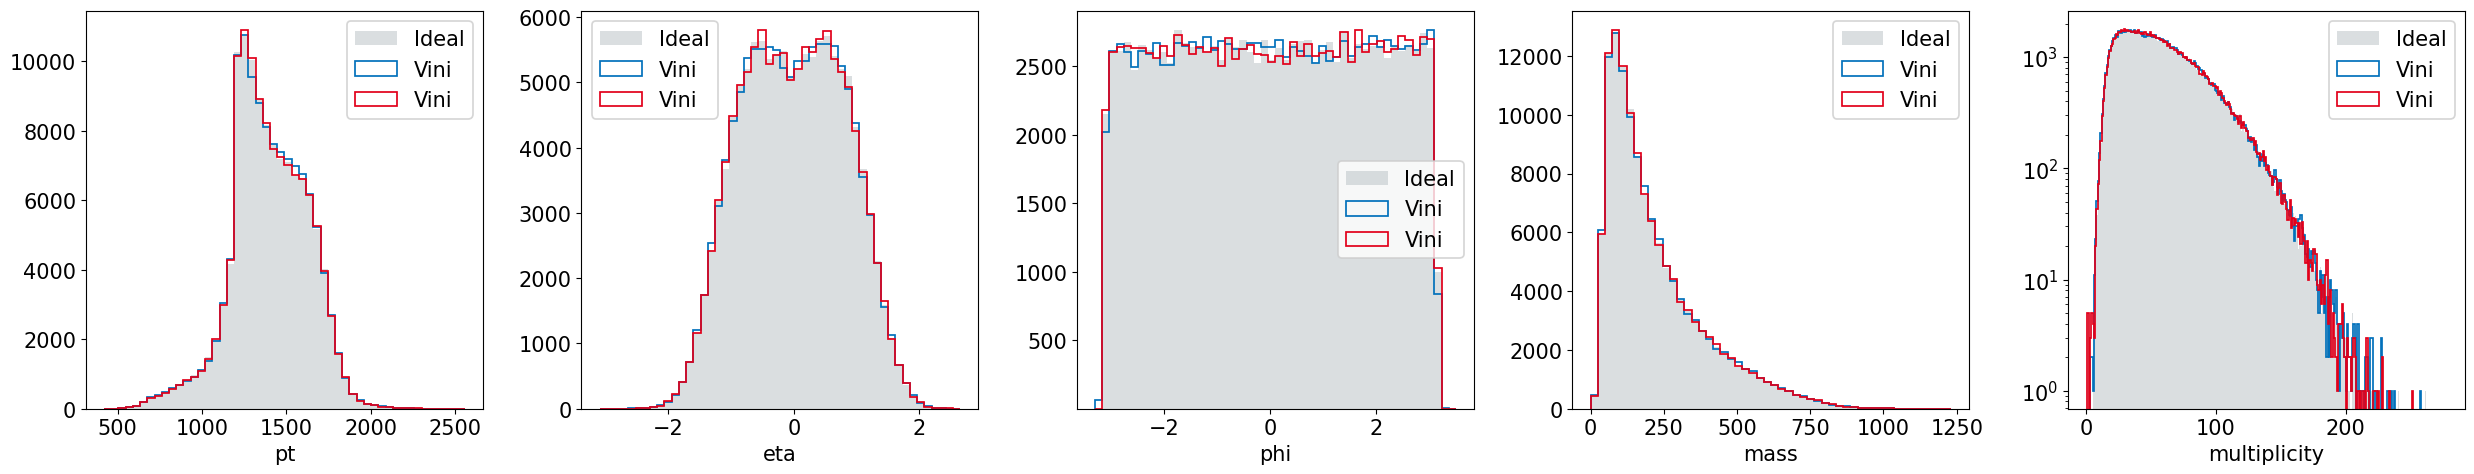

In [29]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(jet_features_id_shuffled[..., i][:,1]), np.min(jet_features_v_shuffled[...,i][:,1]), np.min(jet_features_c_shuffled[...,i][:,1])), max(np.max(jet_features_id_shuffled[..., i][:,1]), np.max(jet_features_v_shuffled[...,i][:,1]), np.max(jet_features_c_shuffled[...,i][:,1]))
    
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 50
    hist = ax.hist(jet_features_id_shuffled[..., i][:,1].flatten()[jet_features_id_shuffled[..., i][:,1].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    cycle = ax._get_lines.prop_cycler
    next(cycle)
    ax.hist(jet_features_v_shuffled[..., i][:,1].flatten()[jet_features_v_shuffled[..., i][:,0].flatten() != 1], bins=hist[1], label="Vini", histtype="step")
    ax.hist(jet_features_c_shuffled[..., i][:,1].flatten()[jet_features_c_shuffled[..., i][:,0].flatten() != 1], bins=hist[1], label="Vini", histtype="step")
    
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    ax.set_xlabel(labels[i])
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

# Save shuffled data

In [30]:
# load data 
path_true_data_shuffled = "/beegfs/desy/user/ewencedr/data/lhco/generated/idealized_LHCO_shuffled.h5"
with h5py.File(path_true_data_shuffled, "w") as f:
    f.create_dataset("jet_features", data=jet_features_id_shuffled)
    f.create_dataset("particle_features", data=particle_data_id_shuffled)
    f.create_dataset("mjj", data=mjj_id)

In [31]:
# load data 
path_true_datav_shuffled = "/beegfs/desy/user/ewencedr/data/lhco/generated/FPCD_LHCO_SR_shuffled.h5"
with h5py.File(path_true_datav_shuffled, "w") as f:
    f.create_dataset("jet_features", data=jet_features_v_shuffled)
    f.create_dataset("particle_features", data=particle_data_v_shuffled)
    f.create_dataset("mjj", data=mjj_v)

In [33]:
# load data 
path_true_datac_shuffled = "/beegfs/desy/user/ewencedr/data/lhco/generated/lhco-xy-10layer-256latent-logpt-new2m_sr-midpoint-300_shuffled.h5"
with h5py.File(path_true_datac_shuffled, "w") as f:
    f.create_dataset("jet_features", data=jet_features_c_shuffled)
    f.create_dataset("particle_features", data=particle_data_c_shuffled)
    f.create_dataset("mjj", data=mjj_c)

# Look at processed data

In [35]:
# load data 
path_processed_bckg = "/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_background_rel.h5"
with h5py.File(path_processed_bckg, "r") as f:
    jet_data_bckg = f["jet_data"][:]
    constituent_data_bckg = f["constituents"][:]
    mask_bckg = f["mask"][:]

In [45]:
# load data 
path_processed_sig = "/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_signal_rel.h5"
with h5py.File(path_processed_sig, "r") as f:
    jet_data_sig = f["jet_data"][:]
    constituent_data_sig = f["constituents"][:]
    mask_sig = f["mask"][:]

In [46]:
# load data 
path_processed_bckg_nonrel = "/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_background.h5"
with h5py.File(path_processed_bckg_nonrel, "r") as f:
    jet_data_bckg_nonrel = f["jet_data"][:]
    constituent_data_bckg_nonrel = f["constituents"][:]
    mask_bckg_nonrel = f["mask"][:]

In [47]:
# load data 
path_processed_sig_nonrel = "/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_signal.h5"
with h5py.File(path_processed_sig_nonrel, "r") as f:
    jet_data_sig_nonrel = f["jet_data"][:]
    constituent_data_sig_nonrel = f["constituents"][:]
    mask_sig_nonrel = f["mask"][:]

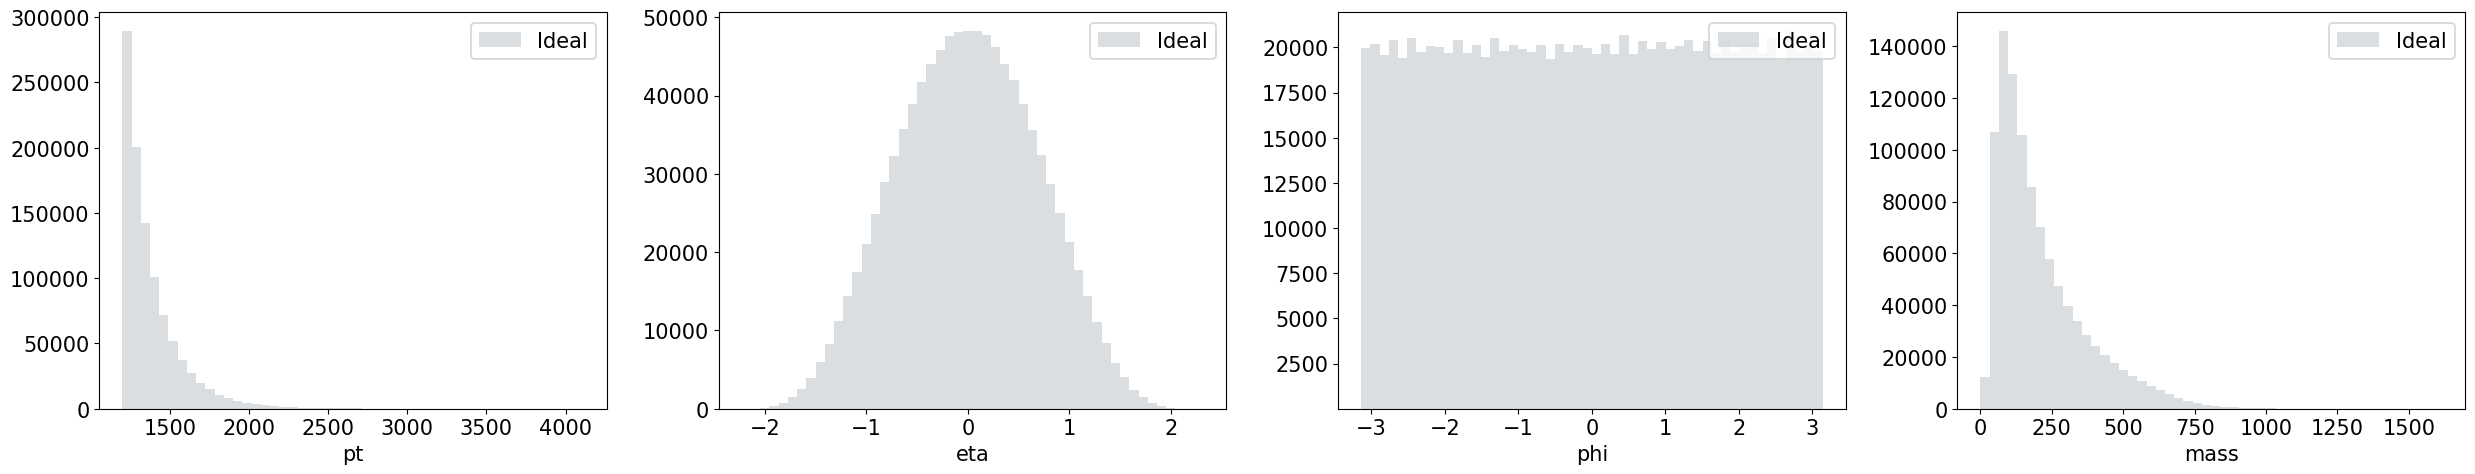

In [39]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 4, figsize=(25, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(jet_features_id_shuffled[..., i][:,1]), np.min(jet_features_v_shuffled[...,i][:,1]), np.min(jet_features_c_shuffled[...,i][:,1])), max(np.max(jet_features_id_shuffled[..., i][:,1]), np.max(jet_features_v_shuffled[...,i][:,1]), np.max(jet_features_c_shuffled[...,i][:,1]))
    min_bin, max_bin = np.min(jet_data_bckg[...,i][:,0]), np.max(jet_data_bckg[...,i][:,0])
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 50
    hist = ax.hist(jet_data_bckg[..., i][:,0].flatten()[jet_data_bckg[..., i][:,0].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    #cycle = ax._get_lines.prop_cycler
    #next(cycle)
    #ax.hist(jet_features_v_shuffled[..., i][:,1].flatten()[jet_features_v_shuffled[..., i][:,0].flatten() != 1], bins=hist[1], label="Vini", histtype="step")
    #ax.hist(jet_features_c_shuffled[..., i][:,1].flatten()[jet_features_c_shuffled[..., i][:,0].flatten() != 1], bins=hist[1], label="Vini", histtype="step")
    
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    ax.set_xlabel(labels[i])
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

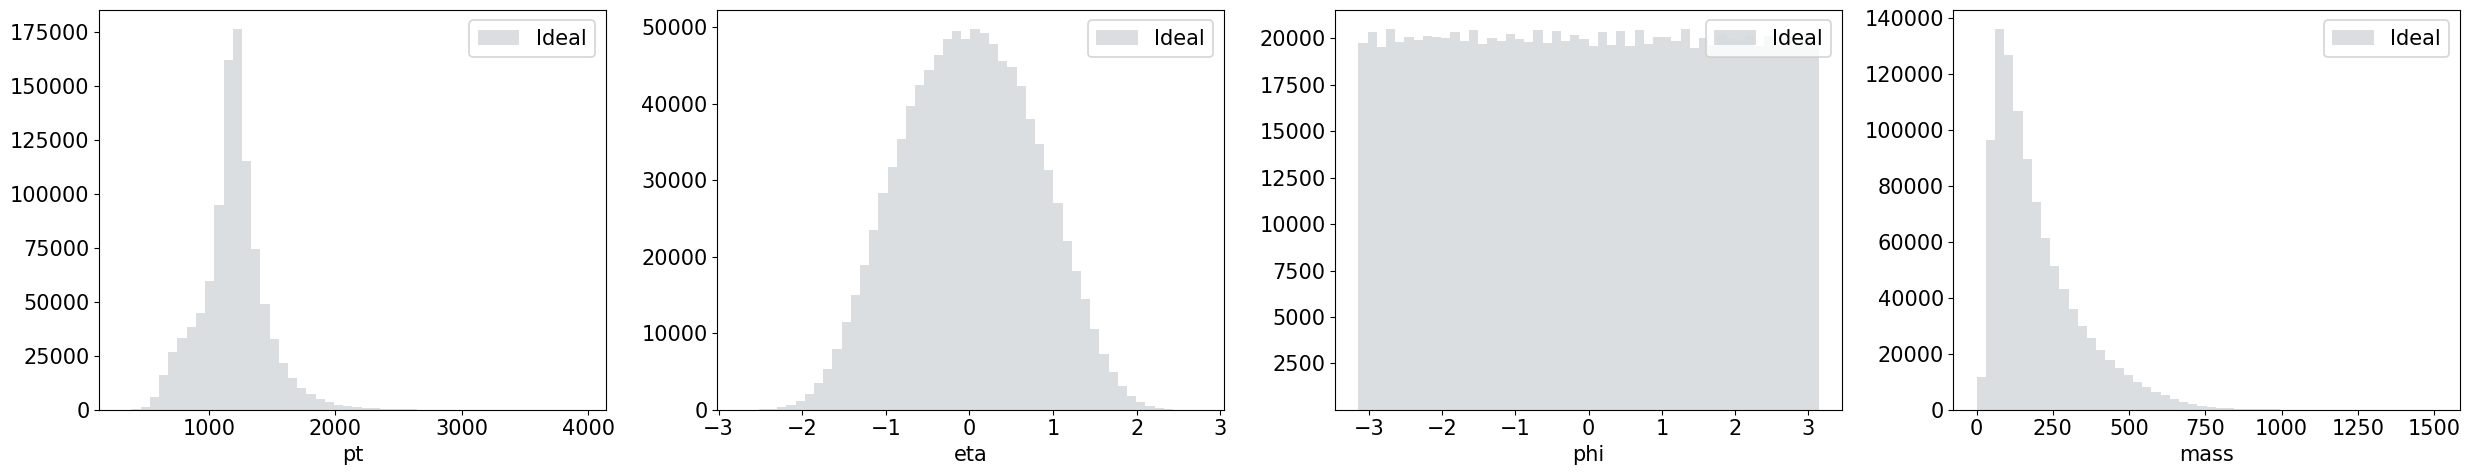

In [40]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 4, figsize=(25, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(jet_features_id_shuffled[..., i][:,1]), np.min(jet_features_v_shuffled[...,i][:,1]), np.min(jet_features_c_shuffled[...,i][:,1])), max(np.max(jet_features_id_shuffled[..., i][:,1]), np.max(jet_features_v_shuffled[...,i][:,1]), np.max(jet_features_c_shuffled[...,i][:,1]))
    min_bin, max_bin = np.min(jet_data_bckg[...,i][:,1]), np.max(jet_data_bckg[...,i][:,1])
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 50
    hist = ax.hist(jet_data_bckg[..., i][:,1].flatten()[jet_data_bckg[..., i][:,1].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    #cycle = ax._get_lines.prop_cycler
    #next(cycle)
    #ax.hist(jet_features_v_shuffled[..., i][:,1].flatten()[jet_features_v_shuffled[..., i][:,0].flatten() != 1], bins=hist[1], label="Vini", histtype="step")
    #ax.hist(jet_features_c_shuffled[..., i][:,1].flatten()[jet_features_c_shuffled[..., i][:,0].flatten() != 1], bins=hist[1], label="Vini", histtype="step")
    
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    ax.set_xlabel(labels[i])
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

In [41]:
def shuffle_jets_2(jets, constiuents, mask):
    pt = jets[:,:,0]
    args = np.argsort(pt, axis=1)[:,::-1]
    #idx = np.random.rand(*jets.shape).argsort(axis=1)
    #print(idx)
    print(args.shape)
    #print(args)
    idx = np.random.rand(*args.shape).argsort(axis=1)
    args = np.take_along_axis(args, idx, axis=1)
    #perm = np.random.permutation(args.shape[])
    #print(perm)
    #args = args[perm]
    print(args)
    shuffled_jets = np.take_along_axis(jets, args[..., None], axis=1)
    shuffled_consts = np.take_along_axis(constiuents, args[..., None, None], axis=1)
    shuffled_mask = np.take_along_axis(mask, args[..., None, None], axis=1)
    #shuffled_jets = np.take_along_axis(jets, idx, axis=1)
    #shuffled_consts = np.take_along_axis(constiuents, idx[..., None], axis=1)
    return shuffled_jets, shuffled_consts, shuffled_mask

In [42]:
jet_data_bckg_shuffled, constituent_data_bckg_shuffled, mask_shuffled = shuffle_jets_2(jet_data_bckg, constituent_data_bckg, mask_bckg)

(1000000, 2)
[[0 1]
 [1 0]
 [0 1]
 ...
 [0 1]
 [1 0]
 [0 1]]


In [48]:
jet_data_sig_shuffled, constituent_data_sig_shuffled, mask_sig_shuffled = shuffle_jets_2(jet_data_sig, constituent_data_sig, mask_sig)
jet_data_bckg_nonrel_shuffled, constituent_data_bckg_nonrel_shuffled, mask_bckg_nonrel_shuffled = shuffle_jets_2(jet_data_bckg_nonrel, constituent_data_bckg_nonrel, mask_bckg_nonrel)
jet_data_sig_nonrel_shuffled, constituent_data_sig_nonrel_shuffled, mask_sig_nonrel_shuffled = shuffle_jets_2(jet_data_sig_nonrel, constituent_data_sig_nonrel, mask_sig_nonrel)

(100000, 2)
[[0 1]
 [1 0]
 [0 1]
 ...
 [1 0]
 [0 1]
 [0 1]]
(1000000, 2)
[[1 0]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]
(100000, 2)
[[1 0]
 [0 1]
 [0 1]
 ...
 [1 0]
 [0 1]
 [0 1]]


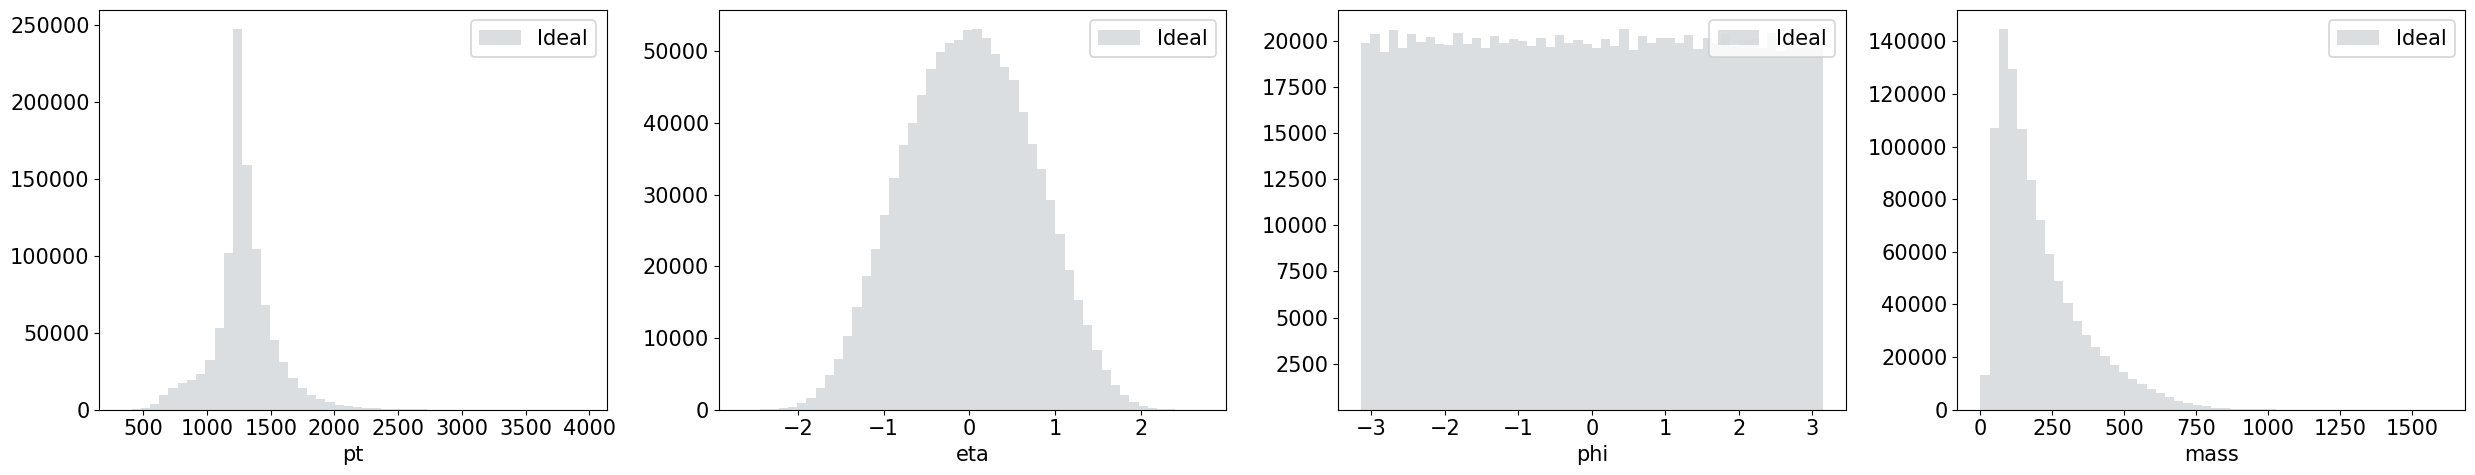

In [43]:
labels = ["pt", "eta", "phi", "mass", "multiplicity"]
fig, axs = plt.subplots(1, 4, figsize=(25, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(jet_features_id_shuffled[..., i][:,1]), np.min(jet_features_v_shuffled[...,i][:,1]), np.min(jet_features_c_shuffled[...,i][:,1])), max(np.max(jet_features_id_shuffled[..., i][:,1]), np.max(jet_features_v_shuffled[...,i][:,1]), np.max(jet_features_c_shuffled[...,i][:,1]))
    min_bin, max_bin = np.min(jet_data_bckg_shuffled[...,i][:,0]), np.max(jet_data_bckg_shuffled[...,i][:,0])
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
        ax.set_yscale("log")
    else:
        bins = 50
    hist = ax.hist(jet_data_bckg_shuffled[..., i][:,0].flatten()[jet_data_bckg_shuffled[..., i][:,0].flatten() != 0], bins=bins, label="Ideal", alpha=0.5, range=(min_bin, max_bin))
    #cycle = ax._get_lines.prop_cycler
    #next(cycle)
    #ax.hist(jet_features_v_shuffled[..., i][:,1].flatten()[jet_features_v_shuffled[..., i][:,0].flatten() != 1], bins=hist[1], label="Vini", histtype="step")
    #ax.hist(jet_features_c_shuffled[..., i][:,1].flatten()[jet_features_c_shuffled[..., i][:,0].flatten() != 1], bins=hist[1], label="Vini", histtype="step")
    
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    ax.set_xlabel(labels[i])
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

## Save again

In [49]:
# load data 
path_processed_bckg_shuffled = "/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_background_rel_shuffled.h5"
with h5py.File(path_processed_bckg_shuffled, "w") as f:
    f.create_dataset("jet_data", data=jet_data_bckg_shuffled)
    f.create_dataset("constituents", data=constituent_data_bckg_shuffled)
    f.create_dataset("mask", data=mask_shuffled)

In [ ]:
# load data 
path_processed_sig_shuffled = "/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_signal_rel_shuffled.h5"
with h5py.File(path_processed_sig_shuffled, "w") as f:
    f.create_dataset("jet_data", data=jet_data_sig_shuffled)
    f.create_dataset("constituents", data=constituent_data_sig_shuffled)
    f.create_dataset("mask", data=mask_sig_shuffled)

In [ ]:
# load data 
path_processed_bckg_nonrel_shuffled = "/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_background_shuffled.h5"
with h5py.File(path_processed_bckg_nonrel_shuffled, "w") as f:
    f.create_dataset("jet_data", data=jet_data_bckg_nonrel_shuffled)
    f.create_dataset("constituents", data=constituent_data_bckg_nonrel_shuffled)
    f.create_dataset("mask", data=mask_bckg_nonrel_shuffled)

In [ ]:
# load data 
path_processed_sig_nonrel_shuffled = "/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_signal_shuffled.h5"
with h5py.File(path_processed_sig_nonrel_shuffled, "w") as f:
    f.create_dataset("jet_data", data=jet_data_sig_nonrel_shuffled)
    f.create_dataset("constituents", data=constituent_data_sig_nonrel_shuffled)
    f.create_dataset("mask", data=mask_sig_nonrel_shuffled)